This notebook is inspired by the notebook in this [Github repo](https://github.com/nicknochnack/TFODCourse) by [Nicholas Renotte](https://youtu.be/yqkISICHH-U?list=PLEG-yoFSLEJ7inw5rNtyqaFAlOHkyWU3t).

NOTE: It's better to run the training in Google Colab to make our life easier, especially since they provide quite decent Linux environment with free GPU support.

Here's a link to redirect you to the Colab Notebook for you to train there: [Training and Detection Notebook](https://colab.research.google.com/github/ansonnn07/object-detection/blob/main/2.%20Training%20and%20Detection.ipynb).

# 0. Setup Config and Paths

In [ ]:
# ONLY for Google Colab
!pip install wget
!git clone https://github.com/ansonnn07/object-detection
%cd "/content/object-detection"

In [1]:
import os
# wget is used to download files from URLs
import wget
# shutil is used to move files
import shutil
import tensorflow as tf

In [2]:
print(tf.__version__)

2.5.0


In [3]:
# check whether tensorflow has access to GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

If this returns an empty list then there is either something wrong with your tensorflow installation, or your machine has no GPU. If you want to use TensorFlow with GPU (recommended), please check this [video link here](https://youtu.be/hHWkvEcDBO0) to try to debug and make sure the cell above returns something like this:

`[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]`

In [147]:
# you may change the MODEL_URL by right-clicking and select "Copy link address" 
# from the models available in TensorFlow Model Zoo here in this link
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md
# generally, the lower the speed/latency the better, the higher the COCO mAP score the better
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz'
PRETRAINED_MODEL_NAME = PRETRAINED_MODEL_URL.split("/")[-1].split(".tar.gz")[0]
CUSTOM_MODEL_NAME = f'my_{PRETRAINED_MODEL_NAME}'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [5]:
PRETRAINED_MODEL_NAME

'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8'

In [150]:
# These directories are used to store our data to use for TFOD API, you don't need to change anything
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [149]:
# these are the paths to our important files
files = {
    'PIPELINE_CONFIG': os.path.join(paths['CHECKPOINT_PATH'], 'pipeline.config'),
    # this generate_tfrecord.py script is modified from https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html
    # to convert our PascalVOC XML annotation files into TFRecords which will be used by the TFOD API
    'GENERATE_TF_RECORD': os.path.join('utils', 'generate_tfrecord.py'),
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [8]:
# create all the necessary paths if not exists yet
for path in paths.values():
    if not os.path.exists(path):
        os.makedirs(path)

# Install TFOD (only need to install once in a virtual environment)

You only need to run this section once in a virtual environment. But in Google Colab, you will need to run this every time. 

In [16]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    # clone the TensorFlow Model Garden repo to use it for TFOD API installation
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [ ]:
# Install Tensorflow Object Detection and dependencies such as protobuf and protoc (for Windows)

if os.name == 'posix':
    # 'posix' is for Linux (also to use in Colab Notebook)
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name == 'nt':
    # 'nt' is for Windows
    print("[INFO] Downloading protobuf dependencies ...")
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    # move the protoc zip file into the desired path, PROTOC_PATH
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    # unzip the zip file
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    # add the path of $PROTOC_PATH/bin into the PATH in environment variable
    # to be able to run `protoc` as a command in terminal
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    # run the `protoc` command and install all the dependencies for TFOD API
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

In [ ]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify all the installation above works for TFOD API
!python {VERIFICATION_SCRIPT}

In [ ]:
!pip uninstall protobuf -y
!pip install protobuf

In [17]:
# restart your Jupyter kernel and run this after installation to confirm the installation works
import object_detection

# 1. Download TF Models Pretrained Models from Tensorflow Model Zoo

In [12]:
import object_detection

In [10]:
if not os.path.exists(os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME)):
    wget.download(PRETRAINED_MODEL_URL)
    pretrained_tarfile = PRETRAINED_MODEL_NAME + '.tar.gz'
    !tar -zxvf {pretrained_tarfile}
    shutil.move(PRETRAINED_MODEL_NAME, paths['PRETRAINED_MODEL_PATH'])
    os.remove(pretrained_tarfile)

# 2. Create Label Map File

**NOTE**: You MUST change this CLASS_NAMES variable according to what you used to label your images in Label Studio. After this, you will not need to change anything other than the pipeline_config and also some output paths that you desire.

In [1]:
CLASS_NAMES = ['coin']
# CLASS_NAMES = ['5', '10', '20', '50']
# CLASS_NAMES = ['1c', '1r', '5', '10', '20','50']
# CLASS_NAMES = ['with_mask', 'without_mask', 'mask_weared_incorrect']

In [14]:
with open(files['LABELMAP'], 'w') as f:
    for idx, label in enumerate(CLASS_NAMES, start=1):
        f.write('item { \n')
        f.write(f'\tname: \'{label}\'\n')
        f.write(f'\tid: {idx}\n')
        f.write('}\n')

In [15]:
print(files['LABELMAP'])
with open(files['LABELMAP']) as f:
    print(f.read())

Tensorflow\workspace\annotations\label_map.pbtxt
item { 
	name: 'coin'
	id: 1
}



In [16]:
from object_detection.utils import label_map_util

label_map = label_map_util.load_labelmap(files['LABELMAP'])
label_map_dict = label_map_util.get_label_map_dict(label_map)
label_map_dict

{'coin': 1}

In [ ]:
# copy the label_map.pbtxt to the export folder to be saved later
shutil.copy2(files['LABELMAP'], paths['OUTPUT_PATH'])

# OPTIONAL - IF RUNNING ON COLAB

- Upload the archive.tar.gz (contains our images and annotation files) that we saved at the end of the previous notebook to YOUR GOOGLE DRIVE's root directory. Then mount it to Google Colab using the code cell below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# the path to the archive tarfile in your Google Drive
ARCHIVE_PATH = "/content/drive/MyDrive/archive.tar.gz"
print(f"archive.tar.gz found: {os.path.exists(ARCHIVE_PATH)}")

In [ ]:
if os.path.exists(ARCHIVE_PATH):
  !tar -zxvf {ARCHIVE_PATH}

# 3. Create TF records

A generate_tfrecord.py script will be used to convert the images and annotations to TFRecords to be used by the TFOD API, the details of it will not be included here as it might overwhelm the users. 

But this script plays a very crucial role to ensure the TFRecord files are created properly for training, so you may refer to it later if you wish to dive deeper into the details.

Run the two commands below and you should see TFRecord files successfully created for both `train.record` and `test.record`.

In [19]:
command = f'python {files["GENERATE_TF_RECORD"]} -x {os.path.join(paths["IMAGE_PATH"], "train")} -e "jpg png" -l {files["LABELMAP"]} -o {os.path.join(paths["ANNOTATION_PATH"], "train.record")}'
print(command)

python utils\generate_tfrecord.py -x Tensorflow\workspace\images\train -e "jpg png" -l Tensorflow\workspace\annotations\label_map.pbtxt -o Tensorflow\workspace\annotations\train.record


In [30]:
!{command}

Successfully created the TFRecord file: Tensorflow\workspace\annotations\train.record


In [31]:
command = f'python {files["GENERATE_TF_RECORD"]} -x {os.path.join(paths["IMAGE_PATH"], "test")} -e "jpg png" -l {files["LABELMAP"]} -o {os.path.join(paths["ANNOTATION_PATH"], "test.record")}'
print(command)

python utils\generate_tfrecord.py -x Tensorflow\workspace\images\test -e "jpg png" -l Tensorflow\workspace\annotations\label_map.pbtxt -o Tensorflow\workspace\annotations\test.record


In [32]:
!{command}

Successfully created the TFRecord file: Tensorflow\workspace\annotations\test.record


# 4. Copy Model Config to Training Folder

In [33]:
original_config = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')
original_config

'Tensorflow\\workspace\\pre-trained-models\\ssd_resnet50_v1_fpn_640x640_coco17_tpu-8\\pipeline.config'

In [34]:
print("New custom config file will be in this folder:", paths['CHECKPOINT_PATH'])

New custom config file will be in this folder: Tensorflow\workspace\models\my_ssd_resnet50_v1_fpn_640x640_coco17_tpu-8


In [35]:
shutil.copy2(original_config, paths['CHECKPOINT_PATH'])

'Tensorflow\\workspace\\models\\my_ssd_resnet50_v1_fpn_640x640_coco17_tpu-8\\pipeline.config'

Then your file directory structure should be something similar as follow:
```
Tensorflow/workspace
├───annotations
├───images
│   ├───collectedimages
│   │   ├───Annotations [XML files]
│   │   └───images [images]
│   ├───test [images & XML files]
│   └───train [images & XML files]
├───models
│   └───my_ssd_resnet50_v1_fpn_640x640_coco17_tpu-8
│           pipeline.config
│
└───pre-trained-models
    └───ssd_resnet50_v1_fpn_640x640_coco17_tpu-8
        │   pipeline.config
        │
        ├───checkpoint
        │       checkpoint
        │       ckpt-0.data-00000-of-00001
        │       ckpt-0.index
        │
        └───saved_model
            │   saved_model.pb
            │
            ├───assets
            └───variables
                    variables.data-00000-of-00001
                    variables.index
```

# 5. Update Config For Transfer Learning

In [36]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [151]:
# the pipeline config file is in
files['PIPELINE_CONFIG']

'Tensorflow\\workspace\\models\\my_ssd_resnet50_v1_fpn_640x640_coco17_tpu-8\\pipeline.config'

In [152]:
# check the config file
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
config

{'model': ssd {
   num_classes: 1
   image_resizer {
     fixed_shape_resizer {
       height: 640
       width: 640
     }
   }
   feature_extractor {
     type: "ssd_resnet50_v1_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 0.00039999998989515007
         }
       }
       initializer {
         truncated_normal_initializer {
           mean: 0.0
           stddev: 0.029999999329447746
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matcher {
     argmax_matcher {
       matched_threshold: 0.5
 

Next, we will update the config using the settings below, you **SHOULD** update manually in the `pipeline.config` file in the `files['PIPELINE_CONFIG']` path to make sure the config works properly.

Follow the parameters listed in the cell outputs below, and update them in the `pipeline.config` file accordingly.

In [ ]:
print("Find and modify the pipeline.config file accordingly in:")
print(files['PIPELINE_CONFIG'])
print()

# num_classes: update num_classes to match the classes/objects in your dataset and mentioned in label_map.pbtxt
# NOTE: the model name may change depending on which model you chose, e.g. ssd
# refer to the config file to confirm, usually it can be found at the second line of the file,
# just after the line of `model` 
num_classes = len(CLASS_NAMES)
print("model.<REFER MODEL NAME IN CONFIG file>.num_classes =", num_classes)

# batch_size: update batch_size based on the system's memory you will be training on. The higher batch_size will need a higher memory
# Guidance for batch_size as mentioned here https://stackoverflow.com/questions/46654424/how-to-calculate-optimal-batch-size/46656508#46656508
# Max batch size= available GPU memory(in bytes) / 4 / (size of tensors + trainable parameters)
batch_size = 2
print("train_config.batch_size =", batch_size)

# fine_tune_checkpoint: mention the path to the checkpoint of the pre-trained model
fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
print(f'train_config.fine_tune_checkpoint = "{fine_tune_checkpoint}"', )

# fine_tune_checkpoint_type: specify “detection” when performing object detection and specify “classification” when performing image classification
fine_tune_checkpoint_type = "detection"
print(f'train_config.fine_tune_checkpoint_type = "{fine_tune_checkpoint_type}"')

# update the label_map_path to point to the label_map.pbtxt file in the annotations folders 
label_map_path= files['LABELMAP']
print(f'train_input_reader.label_map_path = "{label_map_path}"')

# and update the input_path to point to the training TFRecord file in the annotations folder
train_tfrecord_input_path = os.path.join(paths['ANNOTATION_PATH'], 'train.record')
print(f'train_input_reader.tf_record_input_reader.input_path = "{train_tfrecord_input_path}"')

# same thing for test/eval config
print(f'eval_input_reader.label_map_path = "{label_map_path}"')

eval_tfrecord_input_path = os.path.join(paths['ANNOTATION_PATH'], 'test.record')
print(f'eval_input_reader.tf_record_input_reader.input_path = "{eval_tfrecord_input_path}"')

# 6. Train the model

In [46]:
# the path to the training script file `model_main_tf2.py` used to train our model
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')
# change the training steps as necessary, recommended start with 300 to test whether it's working, then train for at least 2000 steps
NUM_TRAIN_STEPS = 300

In [47]:
command = f"python {TRAINING_SCRIPT} --model_dir={paths['CHECKPOINT_PATH']} --pipeline_config_path={files['PIPELINE_CONFIG']} --num_train_steps={NUM_TRAIN_STEPS}"
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_resnet50_v1_fpn_640x640_coco17_tpu-8 --pipeline_config_path=Tensorflow\workspace\models\my_ssd_resnet50_v1_fpn_640x640_coco17_tpu-8\pipeline.config --num_train_steps=300


Copy this command from the cell output above and run it in your terminal at the root directory of this project to start training. Running in terminal instead of Jupyter notebook would be able to see the training process and outputs clearly.

NOTE: Unless you really want to try to train this on your machine locally, it is highly recommended that you run the training in Google Colab **especially if** you don't have access to a good GPU.

In [ ]:
# NOTE: ONLY run this in Colab to start training
!{command}

From [TFOD docs](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html#training-the-model):

Following what people have said online, it seems that it is advisable to allow your model to reach a TotalLoss of at least 2 (ideally 1 and lower) if you want to achieve “fair” detection results. Obviously, lower TotalLoss is better, however very low TotalLoss should be avoided, as the model may end up overfitting the dataset, meaning that it will perform poorly when applied to images outside the dataset. To monitor TotalLoss, as well as a number of other metrics, while your model is training, have a look at Monitor Training Job Progress using TensorBoard.

The next section will show how to use TensorBoard to show the training results.

In [23]:
# our model checkpoints reside in this path
paths['CHECKPOINT_PATH']

'Tensorflow\\workspace\\models\\my_ssd_resnet50_v1_fpn_640x640_coco17_tpu-8'

# Check training results with TensorBoard

In [9]:
print(os.listdir(paths['CHECKPOINT_PATH']))

['checkpoint', 'ckpt-1.data-00000-of-00001', 'ckpt-1.index', 'eval', 'export', 'pipeline.config', 'tfjsexport', 'tfliteexport', 'train']


In [35]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [30]:
%tensorboard --logdir={paths['CHECKPOINT_PATH']}

# 7. Evaluate the Model

In [29]:
command = f"python {TRAINING_SCRIPT} --model_dir={paths['CHECKPOINT_PATH']} --pipeline_config_path={files['PIPELINE_CONFIG']} --checkpoint_dir={paths['CHECKPOINT_PATH']}"
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_resnet50_v1_fpn_640x640_coco17_tpu-8 --pipeline_config_path=Tensorflow\workspace\models\my_ssd_resnet50_v1_fpn_640x640_coco17_tpu-8\pipeline.config --checkpoint_dir=Tensorflow\workspace\models\my_ssd_resnet50_v1_fpn_640x640_coco17_tpu-8


Copy this command from the cell output above and run it in your terminal at the root directory of this project to evaluate the model. Running in terminal instead of Jupyter notebook would be able to see the process and outputs clearly.

In [ ]:
# NOTE: ONLY run this in Colab to show evaluation
!{command}

# 8. Export the model to use it in other places or for deployment

In [48]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [50]:
command = f"python {FREEZE_SCRIPT} --input_type=image_tensor --pipeline_config_path={files['PIPELINE_CONFIG']} --trained_checkpoint_dir={paths['CHECKPOINT_PATH']} --output_directory={paths['OUTPUT_PATH']}"
print(command)

python Tensorflow\models\research\object_detection\exporter_main_v2.py  --input_type=image_tensor --pipeline_config_path=Tensorflow\workspace\models\my_ssd_resnet50_v1_fpn_640x640_coco17_tpu-8\pipeline.config --trained_checkpoint_dir=Tensorflow\workspace\models\my_ssd_resnet50_v1_fpn_640x640_coco17_tpu-8 --output_directory=Tensorflow\workspace\models\my_ssd_resnet50_v1_fpn_640x640_coco17_tpu-8\export


In [51]:
!{command}

2021-08-13 17:01:23.766020: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library cudart64_110.dll
2021-08-13 17:01:27.553680: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library nvcuda.dll
2021-08-13 17:01:27.573379: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.8475GHz coreCount: 10 deviceMemorySize: 6.00GiB deviceMemoryBandwidth: 178.99GiB/s
2021-08-13 17:01:27.573401: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library cudart64_110.dll
2021-08-13 17:01:27.578020: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library cublas64_11.dll
2021-08-13 17:01:27.578039: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library cubla

In [53]:
CUSTOM_MODEL_NAME

'my_ssd_resnet50_v1_fpn_640x640_coco17_tpu-8'

In [ ]:
# tar the exported model to be used anywhere
# !tar -czf models.tar.gz {paths['CHECKPOINT_PATH']}

!tar -czf {CUSTOM_MODEL_NAME}.tar.gz {paths['OUTPUT_PATH']}
print(f"{CUSTOM_MODEL_NAME}.tar.gz saved at current directory.")

The code cell below is used in Google Colab to copy your model to your Google Drive.

In [ ]:
# ONLY in Google Colab
shutil.copy2(f"{CUSTOM_MODEL_NAME}.tar.gz", "/content/drive/MyDrive")

# 9. Load Trained Model From Checkpoint

In [59]:
print("Our exported model is in:\n", paths['OUTPUT_PATH'])

Our exported model is in:
 Tensorflow\workspace\models\my_ssd_resnet50_v1_fpn_640x640_coco17_tpu-8\export


In [63]:
#Import the required libraries for Object detection infernece
import time
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Loading the exported model from the saved_model directory
# you may change this to any other path based on where you exported and stored the model
PATH_TO_SAVED_MODEL = os.path.join(paths['OUTPUT_PATH'], "saved_model")

print('Loading model...', end='')
start_time = time.perf_counter()
# LOAD SAVED MODEL AND BUILD DETECTION FUNCTION
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)
end_time = time.perf_counter()
print(f'Done! Took {end_time - start_time} seconds')

Loading model...Done! Took 9.853315600000315 seconds


In [64]:
# LOAD LABEL MAP DATA
PATH_TO_LABELS = files["LABELMAP"]
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)
category_index

{1: {'id': 1, 'name': 'coin'}}

# 10. Detect from an Image

In [139]:
from imutils.paths import list_images
import numpy as np

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.
    Puts image into numpy array of shape (height, width, channels), where channels=3 for RGB to feed into tensorflow graph.
    Args:
      path: the file path to the image
    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    img = cv2.imread(path)
    # convert from OpenCV's BGR to RGB format
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return np.array(img)

def detect(image_np):
    start_t = time.perf_counter()
    # Running the infernce on the image specified in the  image path
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.expand_dims`.
    input_tensor = input_tensor[tf.newaxis, ...]
    # input_tensor = tf.expand_dims(input_tensor, 0)

    # running detection using the loaded model
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    #print(detections['detection_classes'])
    end_t = time.perf_counter()
    print(f'[INFO] Done inference. [{end_t - start_t:.2f} secs]')
    
    return detections

def draw_results(detections, image_np, min_score_thresh=0.6):
    label_id_offset = 1
    image_np_with_detections = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                # detections['detection_classes'] + label_id_offset,
                detections['detection_classes'],
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=20,
                min_score_thresh=min_score_thresh,
                agnostic_mode=False
    )
    return image_np_with_detections

[INFO] Detecting from the image Tensorflow/workspace/images/test/IMG_3592_M2MGdWa.jpg ...
[INFO] Done inference. [0.14 secs]


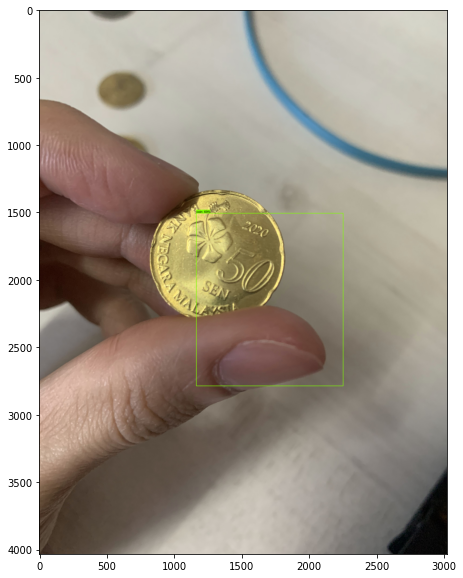

In [140]:
## Inference for a single image

# setting min confidence threshold
# lower this to obtain more detections
MIN_CONF_THRESH=0.5

# ## Randomly select one image from the img_paths
# img_paths = list(list_images(os.path.join(paths["IMAGE_PATH"], 'test')))
# img_path = np.random.choice(img_paths)
## Or specifically select one image
img_path = r"Tensorflow/workspace/images/test/IMG_3592_M2MGdWa.jpg"

image_np = load_image_into_numpy_array(img_path)
print(f"[INFO] Detecting from the image {img_path} ...")
detections = detect(image_np)
image_np_with_detections = draw_results(detections, image_np, MIN_CONF_THRESH)

fig = plt.figure()
fig.set_size_inches(10, 10)
plt.imshow(image_np_with_detections)
plt.show()

The detection results are very bad since I only trained for 300 steps just for testing. You should train for at least 2000 steps or even more, since people usually train for hours.

[INFO] Detecting from the image Tensorflow\workspace\images\test\IMG_3577_FCR3yxg.jpg ...
[INFO] Done inference. [0.13 secs]
[INFO] Detecting from the image Tensorflow\workspace\images\test\IMG_3589_waqmwT3.jpg ...
[INFO] Done inference. [0.12 secs]
[INFO] Detecting from the image Tensorflow\workspace\images\test\IMG_3592_M2MGdWa.jpg ...
[INFO] Done inference. [0.12 secs]
[INFO] Detecting from the image Tensorflow\workspace\images\test\IMG_3578_98uDUAQ.jpg ...
[INFO] Done inference. [0.12 secs]


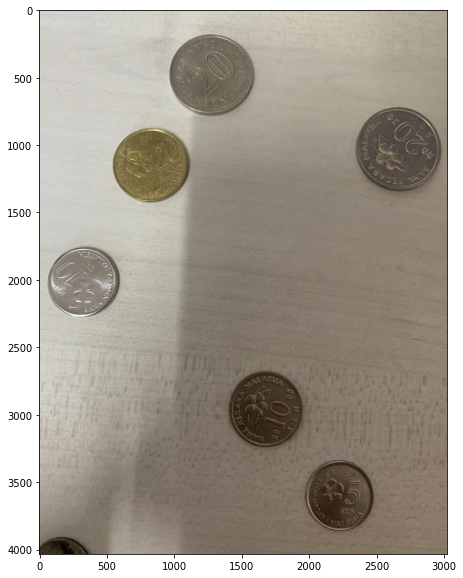

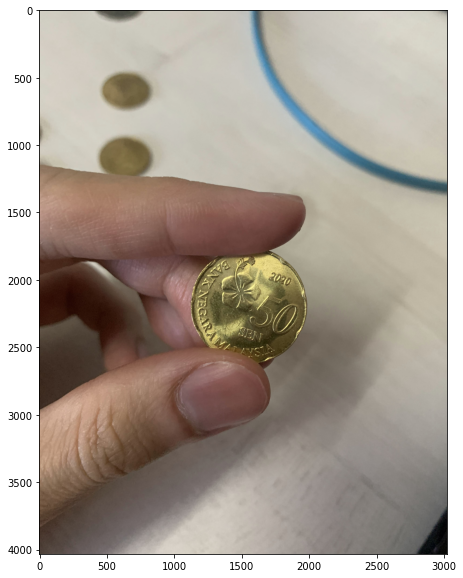

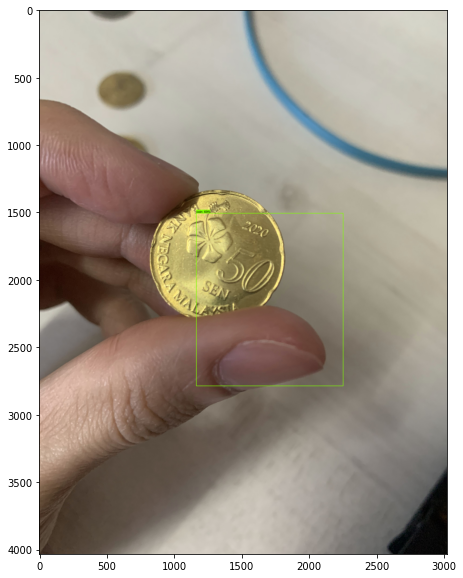

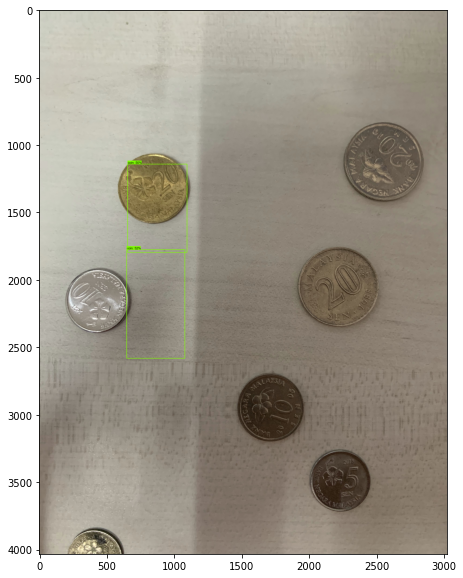

In [145]:
## Or randomly select some from the img_paths
for p in np.random.choice(img_paths, 4, replace=False):
    image_np = load_image_into_numpy_array(p)
    print(f"[INFO] Detecting from the image {p} ...")
    detections = detect(image_np)
    image_np_with_detections = draw_results(detections, image_np, MIN_CONF_THRESH)

    fig = plt.figure()
    fig.set_size_inches(10, 10)
    plt.imshow(image_np_with_detections)
plt.show()

# 11. Real Time Detections from your Webcam

In [ ]:
## this is only needed when unknown errors related to OpenCV occurs
# !pip uninstall opencv-python-headless -y

This code cell below will turn on your camera and detect the objects that you have trained your model on. In the case of the coin dataset, it will proabbly not work well because I have trouble making a Logitech Webcam to focus onto any coin, which makes the inference even more difficult to run.

NOTE: This does not work in Google Colab, because it cannot access your webcam on your local machine from the cloud.

In [60]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    if not ret:
        break
    
    # convert to numpy array
    image_np = np.array(frame)
    
    # run inference
    detections = detect(image_np)
    # draw results
    image_np_with_detections = draw_results(detections, image_np)
    resized_result = cv2.resize(image_np_with_detections, (800, 600))

    cv2.imshow('object detection', resized_result)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()

# Archive

The rest of the code cells are not usually needed

## Conversion to TFJS

In [ ]:
!pip install tensorflowjs

In [ ]:
command = "tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default {} {}".format(os.path.join(paths['OUTPUT_PATH'], 'saved_model'), paths['TFJS_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
# Test Code: https://github.com/nicknochnack/RealTimeSignLanguageDetectionwithTFJS

## Conversion to TFLite

In [ ]:
TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_graph_tf2.py ')

In [ ]:
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['TFLITE_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
FROZEN_TFLITE_PATH = os.path.join(paths['TFLITE_PATH'], 'saved_model')
TFLITE_MODEL = os.path.join(paths['TFLITE_PATH'], 'saved_model', 'detect.tflite')

In [ ]:
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )

In [ ]:
print(command)

In [ ]:
!{command}